In [ ]:
%cd /content/drive/My\ Drive/DigiLab

/content/drive/My Drive/DigiLab


In [ ]:
!pip install mlbox

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd

In [ ]:
import os
import matplotlib.pyplot as plt
from random import sample
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from IPython.display import Image   
from pydotplus import graph_from_dot_data
import sklearn

In [ ]:
from mlbox.preprocessing import *
from mlbox.optimisation import *
from mlbox.prediction import *

In [ ]:
Xevents = pd.read_csv('train_events.csv')
Xcustom = pd.read_csv('train_customers.csv')

testcustom = pd.read_csv('live_customers.csv')
testevents = pd.read_csv('live_events.csv')

In [ ]:
%%time
sns_plot = sns.pairplot(Xcustom, height=2.5)
sns_plot.savefig("output_train.png")

%%time
sns_plot = sns.pairplot(testcustom, height=2.5)
sns_plot.savefig("output_test.png")

In [ ]:
Xcustom.apply(lambda x: sum(x.isnull()), axis=0)

id                               0
gender                           0
tenure_days                      0
age                              0
primary_address_city             0
italian_citizenship_dummy        0
student_dummy                    0
worker_dummy                     0
promo_dummy                      0
love_dummy                       0
estinction_date              49797
churn_dummy                      0
dtype: int64

In [ ]:
Xevents.apply(lambda x: sum(x.isnull()), axis=0)

ids_id        0
tp_mov_gk     0
co_naz_iso    0
dv_mov        0
im_mov        0
tipo_carta    0
new_dt_ope    0
dtype: int64

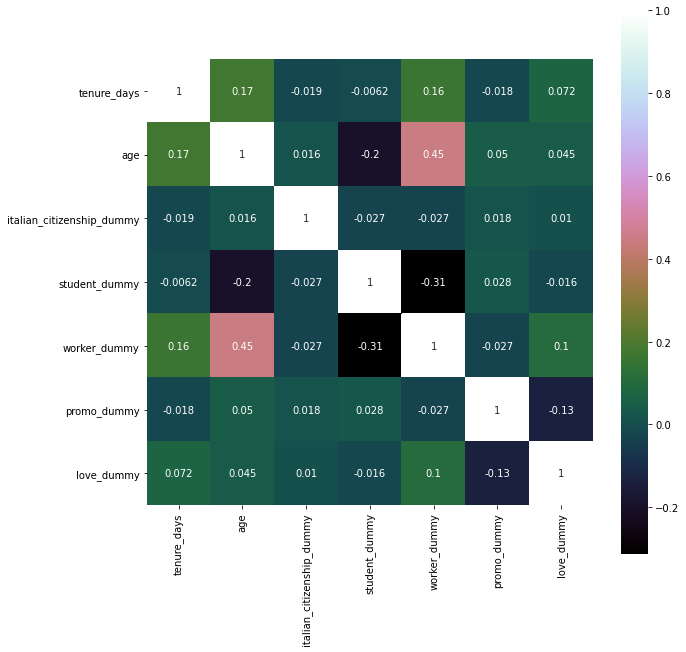

In [ ]:
correlation = Xcustom.loc[:, Xcustom.columns != 'churn_dummy'].corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')

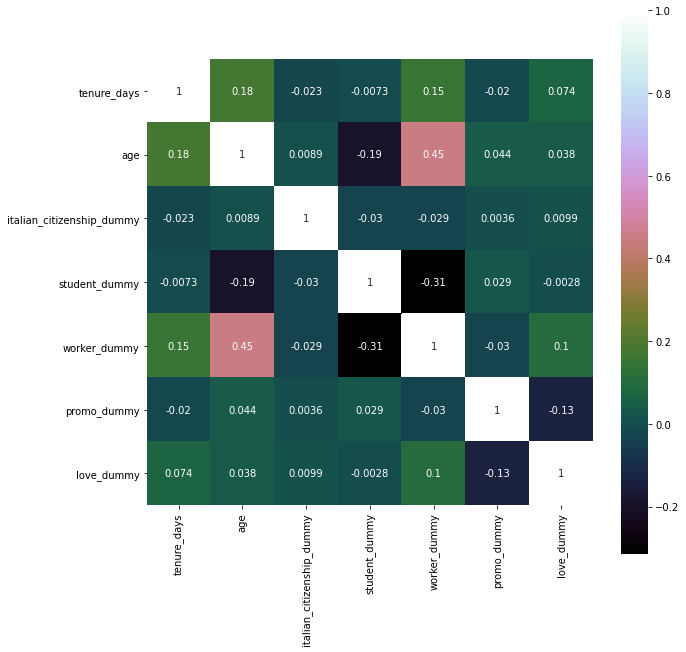

In [ ]:
correlation = testcustom.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')

In [ ]:
def gendr(gen):
    if gen == 'M':
        return 1
    else:
        return 0      

In [ ]:
Xcustom['gender'] = Xcustom.gender.apply(gendr)

testcustom['gender'] = testcustom.gender.apply(gendr)

In [ ]:
ids = Xcustom.groupby('primary_address_city').count().sort_values('id')[['id']]
ids

,id
primary_address_city,
FRASCATI,15
ROVERETO,15
SAN GIOVANNI ROTONDO,17
CASSINO,19
ABANO TERME,20
...,...
NAPOLI,957
TORINO,1230
MILANO,3059


In [ ]:
tids = testcustom.groupby('primary_address_city').count().sort_values('id')[['id']]
tids

,id
primary_address_city,
TREVIGLIO,18
CESANO BOSCONE,18
MONTEBELLUNA,18
CHIERI,19
SAN GIUSEPPE VESUVIANO,19
...,...
NAPOLI,948
TORINO,1194
MILANO,3095


In [ ]:
dummies = Xcustom.groupby('primary_address_city').sum()[['churn_dummy']].sort_values('churn_dummy')
dummies

,churn_dummy
primary_address_city,
VOGHERA,0
MARTINA FRANCA,0
MASCALUCIA,0
MASSA,0
MASSAFRA,0
...,...
VERONA,5
TORINO,5
MILANO,8


In [ ]:
dcoef = ids.merge(dummies, how = 'left', right_on='primary_address_city', left_on='primary_address_city').reset_index()
dcoef.sort_values('churn_dummy').tail(10)

,primary_address_city,id,churn_dummy
182,MOLFETTA,48,3
215,PISTOIA,57,3
328,PALERMO,686,3
329,NAPOLI,957,3
319,ALTAMURA,237,4
330,TORINO,1230,5
326,VERONA,444,5
331,MILANO,3059,8
332,ROMA,3296,12
333,*,20134,79


In [ ]:
city_list = list(dcoef[dcoef['churn_dummy']>3]['primary_address_city'])
city_list

['ALTAMURA', 'VERONA', 'TORINO', 'MILANO', 'ROMA', '*']

In [ ]:
def city(ct):
    if ct in city_list:
        return ct
    else: return 'province'

In [ ]:
Xcustom['primary_address_city_group'] = Xcustom['primary_address_city'].apply(city)
Xcustom.head()

,id,gender,tenure_days,age,primary_address_city,italian_citizenship_dummy,student_dummy,worker_dummy,promo_dummy,love_dummy,estinction_date,churn_dummy,primary_address_city_group
0,038MOS113T9d1b319LY8AbIe,1,487,37,MILANO,1,0,1,0,0,NaN,0,MILANO
1,8fMOfafc2ST63aL6416a0YAI,1,621,28,*,1,0,1,0,0,NaN,0,*
2,eM7Oe36ec66f8STbL9Y01A5I,1,246,20,*,1,0,0,0,0,NaN,0,*
3,430Mf93OSf8T953LbYb3A6I7,1,63,28,*,1,0,0,1,0,NaN,0,*
4,ef63MaOSe0T16LYA152I3f47,1,519,29,*,1,1,0,1,0,NaN,0,*


In [ ]:
testcustom['primary_address_city_group'] = testcustom['primary_address_city'].apply(city)
testcustom.head()

,id,gender,tenure_days,age,primary_address_city,italian_citizenship_dummy,student_dummy,worker_dummy,promo_dummy,love_dummy,estinction_date,primary_address_city_group
0,MO1b8S0c091T13LY552a8AId,0,396,26,PALERMO,1,0,0,0,0,NaN,province
1,a7M5c44OSbTLdY368A571I18,0,463,67,MILANO,1,0,1,1,0,NaN,MILANO
2,d27bd2M7512OS8TaLabYAdI4,1,29,22,*,1,0,0,0,0,NaN,*
3,0c524b2c4MOSb4T8Lcf9YAI0,0,58,23,TERNI,1,0,0,1,0,NaN,province
4,2M66O815S91303359TLYA5I7,1,540,35,BELLUNO,1,0,1,1,1,NaN,province


In [ ]:
dcoef['primary_address_city_group'] = dcoef['primary_address_city'].apply(city)
dummyc = dcoef.groupby('primary_address_city_group').sum().reset_index()
dummyc['dc'] = dummyc['churn_dummy']/dummyc['id']
dummyc = dummyc.drop(['id', 'churn_dummy'], axis = 1)
dummyc.head()

,primary_address_city_group,dc
0,*,0.003924
1,ALTAMURA,0.016878
2,MILANO,0.002615
3,ROMA,0.003641
4,TORINO,0.004065


In [ ]:
Xcustom = Xcustom.drop(['primary_address_city', 'estinction_date'], axis = 1)
Xcustom.head()

,id,gender,tenure_days,age,italian_citizenship_dummy,student_dummy,worker_dummy,promo_dummy,love_dummy,churn_dummy,primary_address_city_group
0,038MOS113T9d1b319LY8AbIe,1,487,37,1,0,1,0,0,0,MILANO
1,8fMOfafc2ST63aL6416a0YAI,1,621,28,1,0,1,0,0,0,*
2,eM7Oe36ec66f8STbL9Y01A5I,1,246,20,1,0,0,0,0,0,*
3,430Mf93OSf8T953LbYb3A6I7,1,63,28,1,0,0,1,0,0,*
4,ef63MaOSe0T16LYA152I3f47,1,519,29,1,1,0,1,0,0,*


In [ ]:
testcustom['target'] = testcustom.apply(lambda x: 0 if pd.isna(x['estinction_date']) else 1, axis=1)

In [ ]:
testcustom = testcustom.drop(['primary_address_city', 'estinction_date'], axis = 1)
testcustom.head()

,id,gender,tenure_days,age,italian_citizenship_dummy,student_dummy,worker_dummy,promo_dummy,love_dummy,primary_address_city_group,target
0,MO1b8S0c091T13LY552a8AId,0,396,26,1,0,0,0,0,province,0
1,a7M5c44OSbTLdY368A571I18,0,463,67,1,0,1,1,0,MILANO,0
2,d27bd2M7512OS8TaLabYAdI4,1,29,22,1,0,0,0,0,*,0
3,0c524b2c4MOSb4T8Lcf9YAI0,0,58,23,1,0,0,1,0,province,0
4,2M66O815S91303359TLYA5I7,1,540,35,1,0,1,1,1,province,0


In [ ]:
Xcustom['primary_address_city_group'] = 'cities_' + Xcustom['primary_address_city_group'].astype(str)
testcustom['primary_address_city_group'] = 'cities_' + testcustom['primary_address_city_group'].astype(str)

In [ ]:
one_hot_cities = pd.get_dummies(Xcustom['primary_address_city_group'])
Xcustom = Xcustom.join(one_hot_cities)

In [ ]:
one_hot_cities = pd.get_dummies(testcustom['primary_address_city_group'])
testcustom = testcustom.join(one_hot_cities)

In [ ]:
testcustom.head()

,id,gender,tenure_days,age,italian_citizenship_dummy,student_dummy,worker_dummy,promo_dummy,love_dummy,primary_address_city_group,target,cities_*,cities_ALTAMURA,cities_MILANO,cities_ROMA,cities_TORINO,cities_VERONA,cities_province
0,MO1b8S0c091T13LY552a8AId,0,396,26,1,0,0,0,0,cities_province,0,0,0,0,0,0,0,1
1,a7M5c44OSbTLdY368A571I18,0,463,67,1,0,1,1,0,cities_MILANO,0,0,0,1,0,0,0,0
2,d27bd2M7512OS8TaLabYAdI4,1,29,22,1,0,0,0,0,cities_*,0,1,0,0,0,0,0,0
3,0c524b2c4MOSb4T8Lcf9YAI0,0,58,23,1,0,0,1,0,cities_province,0,0,0,0,0,0,0,1
4,2M66O815S91303359TLYA5I7,1,540,35,1,0,1,1,1,cities_province,0,0,0,0,0,0,0,1


In [ ]:
Xcustom = Xcustom.drop(['primary_address_city_group', 'cities_*'], axis=1)
testcustom = testcustom.drop(['primary_address_city_group', 'cities_*'], axis=1)

###Начинаем работать с транзакциями

In [ ]:
Xevents['new_dt_ope'] = pd.to_datetime(Xevents['new_dt_ope'], format='%Y-%m-%d %H:%M:%S' )
testevents['new_dt_ope'] = pd.to_datetime(testevents['new_dt_ope'], format='%Y-%m-%d %H:%M:%S' )

In [ ]:
Xevents['today_dt']=Xevents.new_dt_ope.max()
testevents['today_dt']=testevents.new_dt_ope.max()

In [ ]:
Xevents['day_diff']=(Xevents['today_dt']-Xevents.new_dt_ope).dt.days
testevents['day_diff']=(testevents['today_dt']-testevents.new_dt_ope).dt.days

In [ ]:
df_1 = Xevents.groupby('ids_id').min()[['day_diff']].reset_index()
df_1.rename(columns={'day_diff': 'last_txn_d'}, inplace=True)
df_1.head()

,ids_id,last_txn_d
0,000MO9200ST0dL28cbYAfI22,9
1,00275MO17S0T9LYbbf08AI0d,10
2,002MO5dSTL981Y5476Af1d4I,30
3,002MedO23efS9TL708Y7AbId,1
4,00393feMOS01a2Td13dLYAeI,8


In [ ]:
tdf_1 = testevents.groupby('ids_id').min()[['day_diff']].reset_index()
tdf_1.rename(columns={'day_diff': 'last_txn_d'}, inplace=True)
tdf_1.head()

,ids_id,last_txn_d
0,000MecbO0ca0b0SaaT72LYAI,42
1,000b81cM7cO2S2T8LfaY43AI,0
2,000c6MOSaTbf1LY5A3bI051e,2
3,001Mdc0O87STeLY8AdbIb290,12
4,001MfO4bS1b57TLYAeI985fd,18


In [ ]:
df_2 =Xevents[Xevents.day_diff<=30].groupby('ids_id').count()[['day_diff']].reset_index()
df_2.rename(columns={'day_diff': 'count_txn_30d'}, inplace=True)
df_2.head()

,ids_id,count_txn_30d
0,000MO9200ST0dL28cbYAfI22,5
1,00275MO17S0T9LYbbf08AI0d,2
2,002MO5dSTL981Y5476Af1d4I,1
3,002MedO23efS9TL708Y7AbId,13
4,00393feMOS01a2Td13dLYAeI,4


In [ ]:
tdf_2 =testevents[testevents.day_diff<=30].groupby('ids_id').count()[['day_diff']].reset_index()
tdf_2.rename(columns={'day_diff': 'count_txn_30d'}, inplace=True)
tdf_2.head()

,ids_id,count_txn_30d
0,000b81cM7cO2S2T8LfaY43AI,16
1,000c6MOSaTbf1LY5A3bI051e,7
2,001Mdc0O87STeLY8AdbIb290,2
3,001MfO4bS1b57TLYAeI985fd,1
4,002104dfaM5O64S0TLY04A9I,25


In [ ]:
df_3 =Xevents[Xevents.day_diff<=60].groupby('ids_id').count()[['day_diff']].reset_index()
df_3.rename(columns={'day_diff': 'count_txn_60d'}, inplace=True)
df_3.head()

,ids_id,count_txn_60d
0,000MO9200ST0dL28cbYAfI22,10
1,00275MO17S0T9LYbbf08AI0d,4
2,002MO5dSTL981Y5476Af1d4I,1
3,002MedO23efS9TL708Y7AbId,22
4,00393feMOS01a2Td13dLYAeI,10


In [ ]:
tdf_3 =testevents[testevents.day_diff<=60].groupby('ids_id').count()[['day_diff']].reset_index()
tdf_3.rename(columns={'day_diff': 'count_txn_60d'}, inplace=True)
tdf_3.head()

,ids_id,count_txn_60d
0,000MecbO0ca0b0SaaT72LYAI,3
1,000b81cM7cO2S2T8LfaY43AI,40
2,000c6MOSaTbf1LY5A3bI051e,14
3,001Mdc0O87STeLY8AdbIb290,8
4,001MfO4bS1b57TLYAeI985fd,1


In [ ]:
df_4 =Xevents[Xevents.day_diff<=90].groupby('ids_id').count()[['day_diff']].reset_index()
df_4.rename(columns={'day_diff': 'count_txn_90d'}, inplace=True)
df_4.head()

,ids_id,count_txn_90d
0,000MO9200ST0dL28cbYAfI22,16
1,00275MO17S0T9LYbbf08AI0d,4
2,002MO5dSTL981Y5476Af1d4I,14
3,002MedO23efS9TL708Y7AbId,27
4,00393feMOS01a2Td13dLYAeI,10


In [ ]:
tdf_4 =testevents[testevents.day_diff<=90].groupby('ids_id').count()[['day_diff']].reset_index()
tdf_4.rename(columns={'day_diff': 'count_txn_90d'}, inplace=True)
tdf_4.head()

,ids_id,count_txn_90d
0,000MecbO0ca0b0SaaT72LYAI,8
1,000b81cM7cO2S2T8LfaY43AI,49
2,000c6MOSaTbf1LY5A3bI051e,26
3,001Mdc0O87STeLY8AdbIb290,40
4,001MfO4bS1b57TLYAeI985fd,1


In [ ]:
df_5 =Xevents[Xevents.day_diff<=180].groupby('ids_id').count()[['day_diff']].reset_index()
df_5.rename(columns={'day_diff': 'count_txn_180d'}, inplace=True)
df_5.head()

,ids_id,count_txn_180d
0,000MO9200ST0dL28cbYAfI22,34
1,00275MO17S0T9LYbbf08AI0d,4
2,002MO5dSTL981Y5476Af1d4I,27
3,002MedO23efS9TL708Y7AbId,39
4,00393feMOS01a2Td13dLYAeI,10


In [ ]:
tdf_5 =testevents[testevents.day_diff<=180].groupby('ids_id').count()[['day_diff']].reset_index()
tdf_5.rename(columns={'day_diff': 'count_txn_180d'}, inplace=True)
tdf_5.head()

,ids_id,count_txn_180d
0,000MecbO0ca0b0SaaT72LYAI,13
1,000b81cM7cO2S2T8LfaY43AI,62
2,000c6MOSaTbf1LY5A3bI051e,33
3,001Mdc0O87STeLY8AdbIb290,75
4,001MfO4bS1b57TLYAeI985fd,1


In [ ]:
df_6= Xevents.pivot_table(index = 'ids_id', columns = 'tipo_carta', values = 'im_mov', aggfunc = 'sum', fill_value = 0)
df_6= df_6.reset_index()
df_6.head()

tipo_carta,ids_id,CC,CD
0,000MO9200ST0dL28cbYAfI22,0.0,-1636.37
1,00275MO17S0T9LYbbf08AI0d,0.0,-770.31
2,002MO5dSTL981Y5476Af1d4I,0.0,235.91
3,002MedO23efS9TL708Y7AbId,0.0,-678.09
4,00393feMOS01a2Td13dLYAeI,0.0,-399.76


In [ ]:
tdf_6= testevents.pivot_table(index = 'ids_id', columns = 'tipo_carta', values = 'im_mov', aggfunc = 'sum', fill_value = 0)
tdf_6= tdf_6.reset_index()
tdf_6.head(10)

tipo_carta,ids_id,CC,CD
0,000MecbO0ca0b0SaaT72LYAI,0.0,-4106.58
1,000b81cM7cO2S2T8LfaY43AI,0.0,-1836.67
2,000c6MOSaTbf1LY5A3bI051e,0.0,-460.90
3,001Mdc0O87STeLY8AdbIb290,0.0,-198.41
4,001MfO4bS1b57TLYAeI985fd,0.0,20.00
5,002104dfaM5O64S0TLY04A9I,0.0,232.42
6,002MO2S0bd7TLYceA998bbIe,0.0,-341.76
7,003e05MaOS46TL8f11YAIf19,0.0,1859.49
8,0041MfOf634STL93517YeA7I,0.0,-1454.71
9,00462Mc5OeS3d97b9TLYA8Ic,-1423.8,-3865.55


In [ ]:
df_6['cc_flg'] = df_6['CC'].apply(lambda word: 1 if word != 0 else 0)
df_6.head(10)

tipo_carta,ids_id,CC,CD,cc_flg
0,000MO9200ST0dL28cbYAfI22,0.0,-1636.37,0
1,00275MO17S0T9LYbbf08AI0d,0.0,-770.31,0
2,002MO5dSTL981Y5476Af1d4I,0.0,235.91,0
3,002MedO23efS9TL708Y7AbId,0.0,-678.09,0
4,00393feMOS01a2Td13dLYAeI,0.0,-399.76,0
5,003M48OSb9dbT0cLYAaI1a38,0.0,480.74,0
6,003M4Od3fdS1TLff8Y5Ad5I2,0.0,-146.22,0
7,003MOdcST23L3b2Ya2Aa1I6e,0.0,-805.29,0
8,003cMd8cOSd4cT7Lce8Y4AdI,0.0,-4473.88,0
9,005M2dO5STa87LYfAI4da96a,0.0,1441.08,0


In [ ]:
tdf_6['cc_flg'] = tdf_6['CC'].apply(lambda word: 1 if word != 0 else 0)
tdf_6.head(10)

tipo_carta,ids_id,CC,CD,cc_flg
0,000MecbO0ca0b0SaaT72LYAI,0.0,-4106.58,0
1,000b81cM7cO2S2T8LfaY43AI,0.0,-1836.67,0
2,000c6MOSaTbf1LY5A3bI051e,0.0,-460.90,0
3,001Mdc0O87STeLY8AdbIb290,0.0,-198.41,0
4,001MfO4bS1b57TLYAeI985fd,0.0,20.00,0
5,002104dfaM5O64S0TLY04A9I,0.0,232.42,0
6,002MO2S0bd7TLYceA998bbIe,0.0,-341.76,0
7,003e05MaOS46TL8f11YAIf19,0.0,1859.49,0
8,0041MfOf634STL93517YeA7I,0.0,-1454.71,0
9,00462Mc5OeS3d97b9TLYA8Ic,-1423.8,-3865.55,1


In [ ]:
df_6['cd_flg'] = df_6['CD'].apply(lambda word: 1 if word != 0 else 0)
df_6.head(10)

tipo_carta,ids_id,CC,CD,cc_flg,cd_flg
0,000MO9200ST0dL28cbYAfI22,0.0,-1636.37,0,1
1,00275MO17S0T9LYbbf08AI0d,0.0,-770.31,0,1
2,002MO5dSTL981Y5476Af1d4I,0.0,235.91,0,1
3,002MedO23efS9TL708Y7AbId,0.0,-678.09,0,1
4,00393feMOS01a2Td13dLYAeI,0.0,-399.76,0,1
5,003M48OSb9dbT0cLYAaI1a38,0.0,480.74,0,1
6,003M4Od3fdS1TLff8Y5Ad5I2,0.0,-146.22,0,1
7,003MOdcST23L3b2Ya2Aa1I6e,0.0,-805.29,0,1
8,003cMd8cOSd4cT7Lce8Y4AdI,0.0,-4473.88,0,1
9,005M2dO5STa87LYfAI4da96a,0.0,1441.08,0,1


In [ ]:
tdf_6['cd_flg'] = tdf_6['CD'].apply(lambda word: 1 if word != 0 else 0)
tdf_6.head(10)

tipo_carta,ids_id,CC,CD,cc_flg,cd_flg
0,000MecbO0ca0b0SaaT72LYAI,0.0,-4106.58,0,1
1,000b81cM7cO2S2T8LfaY43AI,0.0,-1836.67,0,1
2,000c6MOSaTbf1LY5A3bI051e,0.0,-460.90,0,1
3,001Mdc0O87STeLY8AdbIb290,0.0,-198.41,0,1
4,001MfO4bS1b57TLYAeI985fd,0.0,20.00,0,1
5,002104dfaM5O64S0TLY04A9I,0.0,232.42,0,1
6,002MO2S0bd7TLYceA998bbIe,0.0,-341.76,0,1
7,003e05MaOS46TL8f11YAIf19,0.0,1859.49,0,1
8,0041MfOf634STL93517YeA7I,0.0,-1454.71,0,1
9,00462Mc5OeS3d97b9TLYA8Ic,-1423.8,-3865.55,1,1


###Добавляем всё в единый маасив

In [ ]:
dt_all = Xcustom.merge(df_1, how = 'left', right_on='ids_id', left_on='id')
dt_all = dt_all.drop(['ids_id'], axis=1)
dt_all.head(10)

,id,gender,tenure_days,age,italian_citizenship_dummy,student_dummy,worker_dummy,promo_dummy,love_dummy,churn_dummy,cities_ALTAMURA,cities_MILANO,cities_ROMA,cities_TORINO,cities_VERONA,cities_province,last_txn_d
0,038MOS113T9d1b319LY8AbIe,1,487,37,1,0,1,0,0,0,0,1,0,0,0,0,0.0
1,8fMOfafc2ST63aL6416a0YAI,1,621,28,1,0,1,0,0,0,0,0,0,0,0,0,NaN
2,eM7Oe36ec66f8STbL9Y01A5I,1,246,20,1,0,0,0,0,0,0,0,0,0,0,0,0.0
3,430Mf93OSf8T953LbYb3A6I7,1,63,28,1,0,0,1,0,0,0,0,0,0,0,0,97.0
4,ef63MaOSe0T16LYA152I3f47,1,519,29,1,1,0,1,0,0,0,0,0,0,0,0,NaN
5,MbOSTLdede63052Y4AdI5457,1,470,23,1,0,0,1,0,0,0,0,0,0,0,1,3.0
6,b4M2fO3204ed21ST6cbL0YAI,1,508,42,1,0,0,1,0,0,0,0,0,0,0,1,NaN
7,M1O8482dS37bTLaYA0287Ib8,0,486,38,1,0,1,1,0,0,0,0,0,0,0,0,64.0
8,fM0OS7e6a2TL7Y7360cA0I98,1,64,28,1,0,0,1,0,0,0,0,0,0,0,0,27.0
9,MO9S2dTbf3920L2eY36eaA3I,1,91,28,0,0,1,1,0,0,0,0,1,0,0,0,0.0


In [ ]:
tdt_all = testcustom.merge(tdf_1, how = 'left', right_on='ids_id', left_on='id')
tdt_all = tdt_all.drop(['ids_id'], axis=1)
tdt_all.head(10)

,id,gender,tenure_days,age,italian_citizenship_dummy,student_dummy,worker_dummy,promo_dummy,love_dummy,target,cities_ALTAMURA,cities_MILANO,cities_ROMA,cities_TORINO,cities_VERONA,cities_province,last_txn_d
0,MO1b8S0c091T13LY552a8AId,0,396,26,1,0,0,0,0,0,0,0,0,0,0,1,4.0
1,a7M5c44OSbTLdY368A571I18,0,463,67,1,0,1,1,0,0,0,1,0,0,0,0,NaN
2,d27bd2M7512OS8TaLabYAdI4,1,29,22,1,0,0,0,0,0,0,0,0,0,0,0,NaN
3,0c524b2c4MOSb4T8Lcf9YAI0,0,58,23,1,0,0,1,0,0,0,0,0,0,0,1,8.0
4,2M66O815S91303359TLYA5I7,1,540,35,1,0,1,1,1,0,0,0,0,0,0,1,0.0
5,bb426MO932b05ST4LYA80bI7,0,526,49,1,0,1,1,0,0,0,0,0,0,0,1,0.0
6,Mf8997O871S9TLYc171dAI4d,1,83,20,1,0,0,1,0,0,0,0,0,0,0,1,0.0
7,5M7OdfST1dcL2e81bccaYAI2,1,377,25,1,0,0,1,0,0,0,0,0,1,0,0,0.0
8,MOSddf65TL09904a3c06YAI4,1,624,28,0,0,1,0,0,0,0,1,0,0,0,0,NaN
9,4aMO8SfT3a0L18f1Y67AI240,1,222,25,0,1,0,0,0,0,0,0,0,0,0,1,0.0


In [ ]:
dt_all = dt_all.merge(df_2, how = 'left', right_on='ids_id', left_on='id')
dt_all = dt_all.drop(['ids_id'], axis=1)
dt_all.head(10)

,id,gender,tenure_days,age,italian_citizenship_dummy,student_dummy,worker_dummy,promo_dummy,love_dummy,churn_dummy,cities_ALTAMURA,cities_MILANO,cities_ROMA,cities_TORINO,cities_VERONA,cities_province,last_txn_d,count_txn_30d
0,038MOS113T9d1b319LY8AbIe,1,487,37,1,0,1,0,0,0,0,1,0,0,0,0,0.0,29.0
1,8fMOfafc2ST63aL6416a0YAI,1,621,28,1,0,1,0,0,0,0,0,0,0,0,0,NaN,NaN
2,eM7Oe36ec66f8STbL9Y01A5I,1,246,20,1,0,0,0,0,0,0,0,0,0,0,0,0.0,21.0
3,430Mf93OSf8T953LbYb3A6I7,1,63,28,1,0,0,1,0,0,0,0,0,0,0,0,97.0,NaN
4,ef63MaOSe0T16LYA152I3f47,1,519,29,1,1,0,1,0,0,0,0,0,0,0,0,NaN,NaN
5,MbOSTLdede63052Y4AdI5457,1,470,23,1,0,0,1,0,0,0,0,0,0,0,1,3.0,14.0
6,b4M2fO3204ed21ST6cbL0YAI,1,508,42,1,0,0,1,0,0,0,0,0,0,0,1,NaN,NaN
7,M1O8482dS37bTLaYA0287Ib8,0,486,38,1,0,1,1,0,0,0,0,0,0,0,0,64.0,NaN
8,fM0OS7e6a2TL7Y7360cA0I98,1,64,28,1,0,0,1,0,0,0,0,0,0,0,0,27.0,1.0
9,MO9S2dTbf3920L2eY36eaA3I,1,91,28,0,0,1,1,0,0,0,0,1,0,0,0,0.0,7.0


In [ ]:
tdt_all = tdt_all.merge(tdf_2, how = 'left', right_on='ids_id', left_on='id')
tdt_all = tdt_all.drop(['ids_id'], axis=1)
tdt_all.head(10)

,id,gender,tenure_days,age,italian_citizenship_dummy,student_dummy,worker_dummy,promo_dummy,love_dummy,target,cities_ALTAMURA,cities_MILANO,cities_ROMA,cities_TORINO,cities_VERONA,cities_province,last_txn_d,count_txn_30d
0,MO1b8S0c091T13LY552a8AId,0,396,26,1,0,0,0,0,0,0,0,0,0,0,1,4.0,17.0
1,a7M5c44OSbTLdY368A571I18,0,463,67,1,0,1,1,0,0,0,1,0,0,0,0,NaN,NaN
2,d27bd2M7512OS8TaLabYAdI4,1,29,22,1,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN
3,0c524b2c4MOSb4T8Lcf9YAI0,0,58,23,1,0,0,1,0,0,0,0,0,0,0,1,8.0,1.0
4,2M66O815S91303359TLYA5I7,1,540,35,1,0,1,1,1,0,0,0,0,0,0,1,0.0,6.0
5,bb426MO932b05ST4LYA80bI7,0,526,49,1,0,1,1,0,0,0,0,0,0,0,1,0.0,10.0
6,Mf8997O871S9TLYc171dAI4d,1,83,20,1,0,0,1,0,0,0,0,0,0,0,1,0.0,9.0
7,5M7OdfST1dcL2e81bccaYAI2,1,377,25,1,0,0,1,0,0,0,0,0,1,0,0,0.0,38.0
8,MOSddf65TL09904a3c06YAI4,1,624,28,0,0,1,0,0,0,0,1,0,0,0,0,NaN,NaN
9,4aMO8SfT3a0L18f1Y67AI240,1,222,25,0,1,0,0,0,0,0,0,0,0,0,1,0.0,22.0


In [ ]:
dt_all = dt_all.merge(df_3, how = 'left', right_on='ids_id', left_on='id')
dt_all = dt_all.drop(['ids_id'], axis=1)
dt_all.head(10)

,id,gender,tenure_days,age,italian_citizenship_dummy,student_dummy,worker_dummy,promo_dummy,love_dummy,churn_dummy,cities_ALTAMURA,cities_MILANO,cities_ROMA,cities_TORINO,cities_VERONA,cities_province,last_txn_d,count_txn_30d,count_txn_60d
0,038MOS113T9d1b319LY8AbIe,1,487,37,1,0,1,0,0,0,0,1,0,0,0,0,0.0,29.0,57.0
1,8fMOfafc2ST63aL6416a0YAI,1,621,28,1,0,1,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
2,eM7Oe36ec66f8STbL9Y01A5I,1,246,20,1,0,0,0,0,0,0,0,0,0,0,0,0.0,21.0,30.0
3,430Mf93OSf8T953LbYb3A6I7,1,63,28,1,0,0,1,0,0,0,0,0,0,0,0,97.0,NaN,NaN
4,ef63MaOSe0T16LYA152I3f47,1,519,29,1,1,0,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN
5,MbOSTLdede63052Y4AdI5457,1,470,23,1,0,0,1,0,0,0,0,0,0,0,1,3.0,14.0,19.0
6,b4M2fO3204ed21ST6cbL0YAI,1,508,42,1,0,0,1,0,0,0,0,0,0,0,1,NaN,NaN,NaN
7,M1O8482dS37bTLaYA0287Ib8,0,486,38,1,0,1,1,0,0,0,0,0,0,0,0,64.0,NaN,NaN
8,fM0OS7e6a2TL7Y7360cA0I98,1,64,28,1,0,0,1,0,0,0,0,0,0,0,0,27.0,1.0,1.0
9,MO9S2dTbf3920L2eY36eaA3I,1,91,28,0,0,1,1,0,0,0,0,1,0,0,0,0.0,7.0,15.0


In [ ]:
tdt_all = tdt_all.merge(tdf_3, how = 'left', right_on='ids_id', left_on='id')
tdt_all = tdt_all.drop(['ids_id'], axis=1)
tdt_all.head(10)

,id,gender,tenure_days,age,italian_citizenship_dummy,student_dummy,worker_dummy,promo_dummy,love_dummy,target,cities_ALTAMURA,cities_MILANO,cities_ROMA,cities_TORINO,cities_VERONA,cities_province,last_txn_d,count_txn_30d,count_txn_60d
0,MO1b8S0c091T13LY552a8AId,0,396,26,1,0,0,0,0,0,0,0,0,0,0,1,4.0,17.0,30.0
1,a7M5c44OSbTLdY368A571I18,0,463,67,1,0,1,1,0,0,0,1,0,0,0,0,NaN,NaN,NaN
2,d27bd2M7512OS8TaLabYAdI4,1,29,22,1,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
3,0c524b2c4MOSb4T8Lcf9YAI0,0,58,23,1,0,0,1,0,0,0,0,0,0,0,1,8.0,1.0,2.0
4,2M66O815S91303359TLYA5I7,1,540,35,1,0,1,1,1,0,0,0,0,0,0,1,0.0,6.0,15.0
5,bb426MO932b05ST4LYA80bI7,0,526,49,1,0,1,1,0,0,0,0,0,0,0,1,0.0,10.0,13.0
6,Mf8997O871S9TLYc171dAI4d,1,83,20,1,0,0,1,0,0,0,0,0,0,0,1,0.0,9.0,9.0
7,5M7OdfST1dcL2e81bccaYAI2,1,377,25,1,0,0,1,0,0,0,0,0,1,0,0,0.0,38.0,82.0
8,MOSddf65TL09904a3c06YAI4,1,624,28,0,0,1,0,0,0,0,1,0,0,0,0,NaN,NaN,NaN
9,4aMO8SfT3a0L18f1Y67AI240,1,222,25,0,1,0,0,0,0,0,0,0,0,0,1,0.0,22.0,45.0


In [ ]:
dt_all = dt_all.merge(df_4, how = 'left', right_on='ids_id', left_on='id')
dt_all = dt_all.drop(['ids_id'], axis=1)
dt_all.head(10)

,id,gender,tenure_days,age,italian_citizenship_dummy,student_dummy,worker_dummy,promo_dummy,love_dummy,churn_dummy,cities_ALTAMURA,cities_MILANO,cities_ROMA,cities_TORINO,cities_VERONA,cities_province,last_txn_d,count_txn_30d,count_txn_60d,count_txn_90d
0,038MOS113T9d1b319LY8AbIe,1,487,37,1,0,1,0,0,0,0,1,0,0,0,0,0.0,29.0,57.0,75.0
1,8fMOfafc2ST63aL6416a0YAI,1,621,28,1,0,1,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN
2,eM7Oe36ec66f8STbL9Y01A5I,1,246,20,1,0,0,0,0,0,0,0,0,0,0,0,0.0,21.0,30.0,37.0
3,430Mf93OSf8T953LbYb3A6I7,1,63,28,1,0,0,1,0,0,0,0,0,0,0,0,97.0,NaN,NaN,NaN
4,ef63MaOSe0T16LYA152I3f47,1,519,29,1,1,0,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN
5,MbOSTLdede63052Y4AdI5457,1,470,23,1,0,0,1,0,0,0,0,0,0,0,1,3.0,14.0,19.0,25.0
6,b4M2fO3204ed21ST6cbL0YAI,1,508,42,1,0,0,1,0,0,0,0,0,0,0,1,NaN,NaN,NaN,NaN
7,M1O8482dS37bTLaYA0287Ib8,0,486,38,1,0,1,1,0,0,0,0,0,0,0,0,64.0,NaN,NaN,1.0
8,fM0OS7e6a2TL7Y7360cA0I98,1,64,28,1,0,0,1,0,0,0,0,0,0,0,0,27.0,1.0,1.0,1.0
9,MO9S2dTbf3920L2eY36eaA3I,1,91,28,0,0,1,1,0,0,0,0,1,0,0,0,0.0,7.0,15.0,15.0


In [ ]:
tdt_all = tdt_all.merge(tdf_4, how = 'left', right_on='ids_id', left_on='id')
tdt_all = tdt_all.drop(['ids_id'], axis=1)
tdt_all.head(10)

,id,gender,tenure_days,age,italian_citizenship_dummy,student_dummy,worker_dummy,promo_dummy,love_dummy,target,cities_ALTAMURA,cities_MILANO,cities_ROMA,cities_TORINO,cities_VERONA,cities_province,last_txn_d,count_txn_30d,count_txn_60d,count_txn_90d
0,MO1b8S0c091T13LY552a8AId,0,396,26,1,0,0,0,0,0,0,0,0,0,0,1,4.0,17.0,30.0,35.0
1,a7M5c44OSbTLdY368A571I18,0,463,67,1,0,1,1,0,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN
2,d27bd2M7512OS8TaLabYAdI4,1,29,22,1,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN
3,0c524b2c4MOSb4T8Lcf9YAI0,0,58,23,1,0,0,1,0,0,0,0,0,0,0,1,8.0,1.0,2.0,2.0
4,2M66O815S91303359TLYA5I7,1,540,35,1,0,1,1,1,0,0,0,0,0,0,1,0.0,6.0,15.0,26.0
5,bb426MO932b05ST4LYA80bI7,0,526,49,1,0,1,1,0,0,0,0,0,0,0,1,0.0,10.0,13.0,13.0
6,Mf8997O871S9TLYc171dAI4d,1,83,20,1,0,0,1,0,0,0,0,0,0,0,1,0.0,9.0,9.0,9.0
7,5M7OdfST1dcL2e81bccaYAI2,1,377,25,1,0,0,1,0,0,0,0,0,1,0,0,0.0,38.0,82.0,115.0
8,MOSddf65TL09904a3c06YAI4,1,624,28,0,0,1,0,0,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN
9,4aMO8SfT3a0L18f1Y67AI240,1,222,25,0,1,0,0,0,0,0,0,0,0,0,1,0.0,22.0,45.0,59.0


In [ ]:
dt_all = dt_all.merge(df_5, how = 'left', right_on='ids_id', left_on='id')
dt_all = dt_all.drop(['ids_id'], axis=1)
dt_all.head(10)

,id,gender,tenure_days,age,italian_citizenship_dummy,student_dummy,worker_dummy,promo_dummy,love_dummy,churn_dummy,cities_ALTAMURA,cities_MILANO,cities_ROMA,cities_TORINO,cities_VERONA,cities_province,last_txn_d,count_txn_30d,count_txn_60d,count_txn_90d,count_txn_180d
0,038MOS113T9d1b319LY8AbIe,1,487,37,1,0,1,0,0,0,0,1,0,0,0,0,0.0,29.0,57.0,75.0,114.0
1,8fMOfafc2ST63aL6416a0YAI,1,621,28,1,0,1,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
2,eM7Oe36ec66f8STbL9Y01A5I,1,246,20,1,0,0,0,0,0,0,0,0,0,0,0,0.0,21.0,30.0,37.0,50.0
3,430Mf93OSf8T953LbYb3A6I7,1,63,28,1,0,0,1,0,0,0,0,0,0,0,0,97.0,NaN,NaN,NaN,1.0
4,ef63MaOSe0T16LYA152I3f47,1,519,29,1,1,0,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
5,MbOSTLdede63052Y4AdI5457,1,470,23,1,0,0,1,0,0,0,0,0,0,0,1,3.0,14.0,19.0,25.0,39.0
6,b4M2fO3204ed21ST6cbL0YAI,1,508,42,1,0,0,1,0,0,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN
7,M1O8482dS37bTLaYA0287Ib8,0,486,38,1,0,1,1,0,0,0,0,0,0,0,0,64.0,NaN,NaN,1.0,3.0
8,fM0OS7e6a2TL7Y7360cA0I98,1,64,28,1,0,0,1,0,0,0,0,0,0,0,0,27.0,1.0,1.0,1.0,1.0
9,MO9S2dTbf3920L2eY36eaA3I,1,91,28,0,0,1,1,0,0,0,0,1,0,0,0,0.0,7.0,15.0,15.0,15.0


In [ ]:
tdt_all = tdt_all.merge(tdf_5, how = 'left', right_on='ids_id', left_on='id')
tdt_all = tdt_all.drop(['ids_id'], axis=1)
tdt_all.head(10)

,id,gender,tenure_days,age,italian_citizenship_dummy,student_dummy,worker_dummy,promo_dummy,love_dummy,target,cities_ALTAMURA,cities_MILANO,cities_ROMA,cities_TORINO,cities_VERONA,cities_province,last_txn_d,count_txn_30d,count_txn_60d,count_txn_90d,count_txn_180d
0,MO1b8S0c091T13LY552a8AId,0,396,26,1,0,0,0,0,0,0,0,0,0,0,1,4.0,17.0,30.0,35.0,48.0
1,a7M5c44OSbTLdY368A571I18,0,463,67,1,0,1,1,0,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN
2,d27bd2M7512OS8TaLabYAdI4,1,29,22,1,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
3,0c524b2c4MOSb4T8Lcf9YAI0,0,58,23,1,0,0,1,0,0,0,0,0,0,0,1,8.0,1.0,2.0,2.0,2.0
4,2M66O815S91303359TLYA5I7,1,540,35,1,0,1,1,1,0,0,0,0,0,0,1,0.0,6.0,15.0,26.0,43.0
5,bb426MO932b05ST4LYA80bI7,0,526,49,1,0,1,1,0,0,0,0,0,0,0,1,0.0,10.0,13.0,13.0,20.0
6,Mf8997O871S9TLYc171dAI4d,1,83,20,1,0,0,1,0,0,0,0,0,0,0,1,0.0,9.0,9.0,9.0,9.0
7,5M7OdfST1dcL2e81bccaYAI2,1,377,25,1,0,0,1,0,0,0,0,0,1,0,0,0.0,38.0,82.0,115.0,152.0
8,MOSddf65TL09904a3c06YAI4,1,624,28,0,0,1,0,0,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN
9,4aMO8SfT3a0L18f1Y67AI240,1,222,25,0,1,0,0,0,0,0,0,0,0,0,1,0.0,22.0,45.0,59.0,72.0


In [ ]:
dt_all = dt_all.merge(df_6, how = 'left', right_on='ids_id', left_on='id')
dt_all = dt_all.drop(['ids_id'], axis=1)
dt_all.head(10)

,id,gender,tenure_days,age,italian_citizenship_dummy,student_dummy,worker_dummy,promo_dummy,love_dummy,churn_dummy,cities_ALTAMURA,cities_MILANO,cities_ROMA,cities_TORINO,cities_VERONA,cities_province,last_txn_d,count_txn_30d,count_txn_60d,count_txn_90d,count_txn_180d,CC,CD,cc_flg,cd_flg
0,038MOS113T9d1b319LY8AbIe,1,487,37,1,0,1,0,0,0,0,1,0,0,0,0,0.0,29.0,57.0,75.0,114.0,-1799.14,1456.98,1.0,1.0
1,8fMOfafc2ST63aL6416a0YAI,1,621,28,1,0,1,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,eM7Oe36ec66f8STbL9Y01A5I,1,246,20,1,0,0,0,0,0,0,0,0,0,0,0,0.0,21.0,30.0,37.0,50.0,0.00,-1730.59,0.0,1.0
3,430Mf93OSf8T953LbYb3A6I7,1,63,28,1,0,0,1,0,0,0,0,0,0,0,0,97.0,NaN,NaN,NaN,1.0,0.00,-5.90,0.0,1.0
4,ef63MaOSe0T16LYA152I3f47,1,519,29,1,1,0,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,MbOSTLdede63052Y4AdI5457,1,470,23,1,0,0,1,0,0,0,0,0,0,0,1,3.0,14.0,19.0,25.0,39.0,0.00,-865.36,0.0,1.0
6,b4M2fO3204ed21ST6cbL0YAI,1,508,42,1,0,0,1,0,0,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,M1O8482dS37bTLaYA0287Ib8,0,486,38,1,0,1,1,0,0,0,0,0,0,0,0,64.0,NaN,NaN,1.0,3.0,0.00,-185.98,0.0,1.0
8,fM0OS7e6a2TL7Y7360cA0I98,1,64,28,1,0,0,1,0,0,0,0,0,0,0,0,27.0,1.0,1.0,1.0,1.0,0.00,1620.00,0.0,1.0
9,MO9S2dTbf3920L2eY36eaA3I,1,91,28,0,0,1,1,0,0,0,0,1,0,0,0,0.0,7.0,15.0,15.0,15.0,0.00,902.57,0.0,1.0


In [ ]:
tdt_all = tdt_all.merge(tdf_6, how = 'left', right_on='ids_id', left_on='id')
tdt_all = tdt_all.drop(['ids_id'], axis=1)
tdt_all.head(10)

,id,gender,tenure_days,age,italian_citizenship_dummy,student_dummy,worker_dummy,promo_dummy,love_dummy,target,cities_ALTAMURA,cities_MILANO,cities_ROMA,cities_TORINO,cities_VERONA,cities_province,last_txn_d,count_txn_30d,count_txn_60d,count_txn_90d,count_txn_180d,CC,CD,cc_flg,cd_flg
0,MO1b8S0c091T13LY552a8AId,0,396,26,1,0,0,0,0,0,0,0,0,0,0,1,4.0,17.0,30.0,35.0,48.0,0.00,-1363.36,0.0,1.0
1,a7M5c44OSbTLdY368A571I18,0,463,67,1,0,1,1,0,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,d27bd2M7512OS8TaLabYAdI4,1,29,22,1,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0c524b2c4MOSb4T8Lcf9YAI0,0,58,23,1,0,0,1,0,0,0,0,0,0,0,1,8.0,1.0,2.0,2.0,2.0,0.00,-3.99,0.0,1.0
4,2M66O815S91303359TLYA5I7,1,540,35,1,0,1,1,1,0,0,0,0,0,0,1,0.0,6.0,15.0,26.0,43.0,-1252.76,-3550.27,1.0,1.0
5,bb426MO932b05ST4LYA80bI7,0,526,49,1,0,1,1,0,0,0,0,0,0,0,1,0.0,10.0,13.0,13.0,20.0,0.00,66.42,0.0,1.0
6,Mf8997O871S9TLYc171dAI4d,1,83,20,1,0,0,1,0,0,0,0,0,0,0,1,0.0,9.0,9.0,9.0,9.0,0.00,-67.39,0.0,1.0
7,5M7OdfST1dcL2e81bccaYAI2,1,377,25,1,0,0,1,0,0,0,0,0,1,0,0,0.0,38.0,82.0,115.0,152.0,0.00,-7049.20,0.0,1.0
8,MOSddf65TL09904a3c06YAI4,1,624,28,0,0,1,0,0,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,4aMO8SfT3a0L18f1Y67AI240,1,222,25,0,1,0,0,0,0,0,0,0,0,0,1,0.0,22.0,45.0,59.0,72.0,0.00,-847.13,0.0,1.0


In [ ]:
values = {'last_txn_d': -1, 'count_txn_30d': -1, 'count_txn_60d': -1, 'count_txn_90d': -1, 'count_txn_180d': -1, 'CC': -1, 'CD': -1, 'cc_flg': -1, 'cd_flg': -1}
dt_all = dt_all.fillna(value=values)
tdt_all = tdt_all.fillna(value=values)

###Разбиение обучаемой выборки и построение моделей

In [ ]:
dt_y = dt_all['churn_dummy']
dt = dt_all.drop(['id', 'churn_dummy'], axis=1)

tdt_y = tdt_all['target']
tdt = tdt_all.drop(['id', 'target'], axis=1)

In [ ]:
dt_y.mean()

0.00406

In [ ]:
tdt_y.mean()

0.00394

In [ ]:
X_train, X_test, y_train, y_test = \
        sklearn.model_selection.train_test_split(dt, dt_y, random_state=42)

In [ ]:
y_train.mean()

0.00424

In [ ]:
y_test.mean()

0.00352

In [ ]:
# Variable importance
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), X_train), reverse=True))

Features sorted by their score:
[(0.3621, 'tenure_days'), (0.1995, 'age'), (0.0877, 'CD'), (0.0496, 'count_txn_180d'), (0.043, 'count_txn_90d'), (0.0398, 'last_txn_d'), (0.0384, 'count_txn_60d'), (0.032, 'count_txn_30d'), (0.0228, 'promo_dummy'), (0.02, 'cities_province'), (0.0182, 'gender'), (0.015, 'worker_dummy'), (0.0124, 'student_dummy'), (0.0107, 'cities_ROMA'), (0.0102, 'italian_citizenship_dummy'), (0.0097, 'love_dummy'), (0.0085, 'CC'), (0.0053, 'cities_MILANO'), (0.0052, 'cities_TORINO'), (0.0038, 'cities_ALTAMURA'), (0.0035, 'cities_VERONA'), (0.0017, 'cc_flg'), (0.0007, 'cd_flg')]


#MLBox

In [ ]:
dt_all.to_csv("dt_all.csv")

In [ ]:
tdt_all.to_csv("tdt_all.csv")

In [ ]:
paths = ["dt_all.csv", "tdt_all.csv"]
target_name = "churn_dummy" #to modify

In [ ]:
data = Reader(sep=",").train_test_split(paths, target_name)  #reading


reading csv : dt_all.csv ...
cleaning data ...
CPU time: 6.1215949058532715 seconds

reading csv : tdt_all.csv ...
cleaning data ...
CPU time: 0.9260311126708984 seconds

> Number of common features : 24

gathering and crunching for train and test datasets ...
reindexing for train and test datasets ...
dropping training duplicates ...
dropping constant variables on training set ...

> Number of categorical features: 1
> Number of numerical features: 23
> Number of training samples : 50000
> Number of test samples : 50000

> You have no missing values on train set...

> Task : classification
0.0    49797
1.0      203
Name: churn_dummy, dtype: int64

encoding target ...


In [ ]:
data = Drift_thresholder().fit_transform(data)  #deleting non-stable variables


computing drifts ...
CPU time: 3.2615718841552734 seconds

> Top 10 drifts

('id', 0.9999799999999999)
('cc_flg', 0.007002994400000073)
('count_txn_30d', 0.005793204000000163)
('worker_dummy', 0.005079999999999973)
('cd_flg', 0.004764420799999947)
('count_txn_180d', 0.004725261599999975)
('cities_province', 0.0036000000000000476)
('cities_ROMA', 0.0032999999999998586)
('student_dummy', 0.0028799999999999937)
('count_txn_60d', 0.002851826400000146)

> Deleted variables : ['id']
> Drift coefficients dumped into directory : save


In [ ]:
space={'ne__numerical_strategy':{"search":"choice","space":['mean','median']},
# 'ne__categorical_strategy':{"search":"choice","space":[np.NaN]},
'ce__strategy':{"search":"choice","space":['label_encoding','entity_embedding','random_projection']},
'fs__strategy':{"search":"choice","space":['l1','variance','rf_feature_importance']},
'fs__threshold':{"search":"uniform","space":[0.01, 0.3]},
'est__max_depth':{"search":"choice","space":[3,5,7,9]},
'est__n_estimators':{"search":"choice","space":[250,500,700,1000]}}

In [ ]:
best=Optimiser(scoring="roc_auc",n_folds=5).optimise(space,data,40)

##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'median', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'random_projection'}
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.10603600967316078}
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 5, 'n_estimators': 250, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
  0%|          | 0/40 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.6/dist-packages/mlbox/optimisation/optimiser.py:74: UserWarning: Optimiser will save all your fitted models into directory 'save/joblib'. Please clear it regularly.
  +str(self.to_path)+"/joblib'. Please clear it regularly.")


MEAN SCORE : roc_auc = 0.6528783408782749
VARIANCE : 0.030523253249446464 (fold 1 = 0.6683032128514055, fold 2 = 0.7010542168674699, fold 3 = 0.6534939593797986, fold 4 = 0.6250860234277611, fold 5 = 0.6164542918649389)
CPU time: 25.54518961906433 seconds
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'random_projection'}
>>> FEATURE SELECTOR :{'strategy': 'variance', 'threshold': 0.1522613335178972}
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 3, 'n_estimators': 500, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': Tr


fitting the pipeline ...
CPU time: 4.333858489990234 seconds


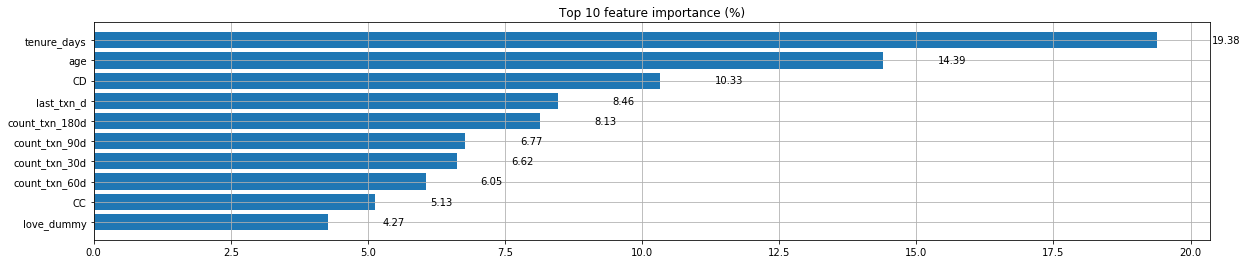


> Feature importances dumped into directory : save

predicting ...
CPU time: 0.7336652278900146 seconds

> Overview on predictions : 

        0.0       1.0  churn_dummy_predicted
0  0.999071  0.000929                      0
1  0.999569  0.000431                      0
2  0.997943  0.002057                      0
3  0.998243  0.001757                      0
4  0.997063  0.002937                      0
5  0.989377  0.010623                      0
6  0.999425  0.000575                      0
7  0.999733  0.000267                      0
8  0.990505  0.009495                      0
9  0.996286  0.003714                      0

dumping predictions into directory : save ...


In [ ]:
Predictor().fit_predict(best,data)

In [ ]:
y_hat = pd.read_csv('save/churn_dummy_predictions.csv')

In [ ]:
col_names = ['id','no','yes','class']
df_hat = y_hat
df_hat = df_hat.rename(index={0: "id", 1: "no", 2: "yes", 3: "class"})

,Unnamed: 0,0.0,1.0,churn_dummy_predicted
id,0,0.999071,0.000929,0
no,1,0.999569,0.000431,0
yes,2,0.997943,0.002057,0
class,3,0.998243,0.001757,0
4,4,0.997063,0.002937,0
...,...,...,...,...
49995,49995,0.998414,0.001586,0
49996,49996,0.999978,0.000022,0
49997,49997,0.999759,0.000241,0
49998,49998,0.996483,0.003517,0


In [ ]:
# col_names = ['id','no','yes','class']
# df_hat = pd.DataFrame(y_hat, columns=col_names)
from sklearn.metrics import roc_auc_score
score = roc_auc_score(tdt_y, df_hat[['1.0']])
score

0.6624761458624137